In [2]:
import numpy as np
import torch
import gif
import matplotlib.pyplot as plt
import pytorch_lightning as pl 
from pathlib import Path
import yaml
from importlib import import_module
from matplotlib.tri import Triangulation as triang
import seaborn

seaborn.set_style("darkgrid")


In [53]:
#### Change the entries here to analyze a new model / dataset
#model_checkpoint_path = Path('C:\\Users\\Kevin\\Google Drive\\Research\\QCbranch\\QuadConv\\lightning_logs\\ignition_small_refined\\lassen_version_0')
model_checkpoint_path = Path('C:\\Users\\Kevin\\OneDrive - UCB-O365\\Documents\\Research\\QuadConv\\lightning_logs\\qcae_pool\\version_13')
###################

model_yml = list(model_checkpoint_path.glob('config.yaml'))

with model_yml[0].open() as file:
    config = yaml.safe_load(file)

#extract args
trainer_args = config['train']
model_args = config['model']
data_args = config['data']
misc_args = config['misc']

checkpoint = list(model_checkpoint_path.rglob('epoch=*.ckpt'))

checkpoint_dict = torch.load(checkpoint[0])

state_dict = checkpoint_dict['state_dict']

In [54]:

#setup datamodule
module = import_module('core.' + data_args.pop('module'))
datamodule = module.DataModule(**data_args)
datamodule.setup(stage='analyze')
dataset = datamodule.analyze_data()

#build model
module = import_module('core.' + model_args.pop('type') + '.model')
model = module.Model(**model_args, data_info = datamodule.get_data_info())

del_list = []
for key in state_dict:
    if 'eval_indices' in key:
        del_list.append(key)

for key in del_list:
    del state_dict[key]

model.load_state_dict(state_dict, strict=False)
model.eval()
model.to('cpu')



Model(
  (loss_fn): MSELoss()
  (mesh): MeshHandler(
    (_points): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 2189x2]
        (1): Parameter containing: [torch.FloatTensor of size 2304x2]
        (2): Parameter containing: [torch.FloatTensor of size 576x2]
        (3): Parameter containing: [torch.FloatTensor of size 144x2]
    )
    (_weights): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 2189]
        (1): Parameter containing: [torch.FloatTensor of size 2304]
        (2): Parameter containing: [torch.FloatTensor of size 576]
        (3): Parameter containing: [torch.FloatTensor of size 144]
    )
    (_adjacency): ParameterList()
  )
  (output_activation): Tanh()
  (encoder): Encoder(
    (init_layer): QuadConv(
      (H): Sequential(
        (0): Linear(in_features=2, out_features=4, bias=False)
        (1): Sin()
        (2): Linear(in_features=4, out_features=4, bias=False)
        (3): Sin()
        (4): Linear(i

In [47]:
for key in state_dict:

    print(key)
        

encoder.cnn.0.eval_locs
encoder.cnn.0.eval_indices
encoder.cnn.0.quad_weights
encoder.cnn.0.G.0.weight
encoder.cnn.0.G.2.weight
encoder.cnn.0.G.4.weight
encoder.cnn.0.G.6.weight
encoder.cnn.1.conv1.eval_locs
encoder.cnn.1.conv1.eval_indices
encoder.cnn.1.conv1.quad_weights
encoder.cnn.1.conv1.G.0.weight
encoder.cnn.1.conv1.G.2.weight
encoder.cnn.1.conv1.G.4.weight
encoder.cnn.1.conv1.G.6.weight
encoder.cnn.1.conv2.eval_locs
encoder.cnn.1.conv2.eval_indices
encoder.cnn.1.conv2.quad_weights
encoder.cnn.1.conv2.G.0.weight
encoder.cnn.1.conv2.G.2.weight
encoder.cnn.1.conv2.G.4.weight
encoder.cnn.1.conv2.G.6.weight
encoder.linear.0.bias
encoder.linear.0.parametrizations.weight.original
encoder.linear.0.parametrizations.weight.0._u
encoder.linear.0.parametrizations.weight.0._v
encoder.linear.2.bias
encoder.linear.2.parametrizations.weight.original
encoder.linear.2.parametrizations.weight.0._u
encoder.linear.2.parametrizations.weight.0._v
decoder.linear.0.bias
decoder.linear.0.parametrization

In [69]:
for name, param in model.named_parameters():
        print(name)

mesh._points.0
mesh._points.1
mesh._points.2
mesh._points.3
mesh._weights.0
mesh._weights.1
mesh._weights.2
mesh._weights.3
encoder.init_layer.H.0.weight
encoder.init_layer.H.2.weight
encoder.init_layer.H.4.weight
encoder.init_layer.H.6.weight
encoder.init_layer.H.8.weight
encoder.init_layer.H.10.weight
encoder.init_layer.H.12.weight
encoder.init_layer.H.14.weight
encoder.qcnn.0.conv1.H.0.weight
encoder.qcnn.0.conv1.H.2.weight
encoder.qcnn.0.conv1.H.4.weight
encoder.qcnn.0.conv1.H.6.weight
encoder.qcnn.0.conv1.H.8.weight
encoder.qcnn.0.conv1.H.10.weight
encoder.qcnn.0.conv1.H.12.weight
encoder.qcnn.0.conv1.H.14.weight
encoder.qcnn.0.conv2.H.0.weight
encoder.qcnn.0.conv2.H.2.weight
encoder.qcnn.0.conv2.H.4.weight
encoder.qcnn.0.conv2.H.6.weight
encoder.qcnn.0.conv2.H.8.weight
encoder.qcnn.0.conv2.H.10.weight
encoder.qcnn.0.conv2.H.12.weight
encoder.qcnn.0.conv2.H.14.weight
encoder.qcnn.1.conv1.H.0.weight
encoder.qcnn.1.conv1.H.2.weight
encoder.qcnn.1.conv1.H.4.weight
encoder.qcnn.1.conv

In [67]:
quad_weights = state_dict['mesh._weights.0'].detach().cpu().numpy()
quad_locations = state_dict['mesh._points.0'].detach().cpu().numpy()

In [68]:
# def functions

f = lambda x,y : x**2 + y**2

g = lambda x,y : np.ones_like(x)


In [71]:

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def integrate_function(function, weights = quad_weights, locations = quad_locations):

    func_vals = function(locations[:,0],locations[:,1])

    return (np.dot( func_vals, sigmoid(weights) ) - np.mean(func_vals)) / np.sqrt(np.var(func_vals) + 1e-5)


def find_gain(weights = quad_weights, locations = quad_locations):

    func_vals = np.ones_like(locations[:,0])

    return np.dot( func_vals, sigmoid(weights) )


In [75]:
print(integrate_function(f) / integrate_function(g))

0.005803146686454828


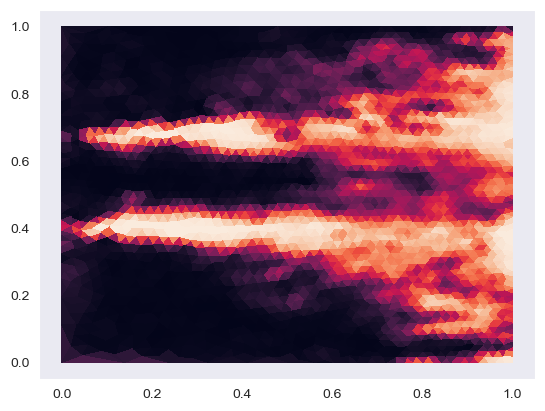

In [52]:
max_disp = 1
min_disp = 0

my_map = seaborn.color_palette(palette='rocket', as_cmap=True)

fig, axs = plt.subplots()

max_x = np.max(quad_locations[:,0])
max_y = np.max(quad_locations[:,1])

flow_tri = triang(quad_locations[:,0], quad_locations[:,1])

map_it0 = axs.tripcolor(flow_tri, sigmoid(quad_weights), facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)